In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
mkdir ~/.kaggle

In [3]:
! cp /content/drive/MyDrive/Stat_Docs/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download kmader/mias-mammography

Dataset URL: https://www.kaggle.com/datasets/kmader/mias-mammography
License(s): other
 82% 254M/312M [00:00<00:00, 697MB/s] 
100% 312M/312M [00:04<00:00, 76.8MB/s]


In [6]:
! unzip /content/mias-mammography.zip -d /content/mias-mammography > /dev/null

In [7]:
# check disk usage
! df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   39G   75G  35% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  775M  61% /usr/sbin/docker-init
/dev/sda1        75G   41G   35G  55% /opt/bin/.nvidia
tmpfs           6.4G   84K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  7.1G  8.0G  48% /content/drive


# Dependencies

In [8]:
# system related
import os
import sys
# path manipulation
from pathlib import Path
# regex
import re
# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle
# data manipulation / preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# image manipulation
from PIL import Image
from IPython.display import Image

# metrics
from sklearn.metrics import confusion_matrix, classification_report

# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Circle


class MammoScan:
    def __init__(self, scan, sc_info):
        self.__scan = scan
        self.__sc_info = sc_info

    @property # scan image
    def scan(self):
        return self.__scan

    @property # scan info
    def scan_info(self):
        return self.__sc_info

    @property # from the scan file name
    def scan_name(self):
        return self.__sc_info.name

    @property # x coordinate of the abnormality
    def x(self):
        return self.__sc_info.x

    @property # y coordinate of the abnormality
    def y(self):
        return self.__sc_info.y

    @property # radius of the abnormality
    def radius(self):
        return self.__sc_info.radius

    @property # class of the abnormality
    def ab_class(self):
        return self.__sc_info.ab_class

    @property # background tissue of the abnormality
    def bg(self):
        return self.__sc_info.bg

    @property # severity of the abnormality
    def severity(self):
        return self.__sc_info.severity

    @property
    # generates cropped downsized rotated images of the abnormality
    def transformations(self):
        return self.__transform()

    @property
    # returns the matricial representation fo the scan image
    def pixel_matrix(self):
        return np.array(self.scan)

    # instance method
    def plot(self):

        # Create a figure. Equal aspect so circles look circular
        fig, ax = plt.subplots(1)

        fig.set_size_inches(8, 6)
        ax.set_aspect('equal')

        # Show the image
        ax.imshow(self.scan, cmap=plt.cm.gray_r)
        ax.set_ylim(bottom=0, top=1024)
        ax.set_title(self.scan_name)


        # create a circle to patch on the image
        x, y, r = self.__get_crop_coords()
        print(f'{x}, {y}, {r}')
        circ = Circle((x,y), r, fill=False)
        ax.add_patch(circ)

    # private method
    def __set_x(self, xValue):
        self.__sc_info.x = xValue

    # private method
    def __set_y(self, yValue):
        self.__sc_info.y = yValue

    # private method
    def __set_radius(self, rValue):
        self.__sc_info.radius = rValue

    # private method
    def __get_crop_coords(self):
        '''Returns a tuple with x, y and r'''
        # check scan class to decide on how to crop
        if pd.isnull(self.radius):
            radius = 48.0
            self.__set_radius(radius)
        if pd.isnull(self.x):
            x = float(np.random.randint(500, 513))
            self.__set_x(x)
        if pd.isnull(self.y):
            y = float(np.random.randint(500, 513))
            self.__set_y(y)

        return (self.x, 1024.0-self.y, self.radius)

    # private method
    def __transform(self):
        '''Creates a dict
                  with rotated and mirrored versions of self.scan'''
        # create dictionary
        transformations = dict()
        # get crop values
        x, y, r = self.__get_crop_coords()
        # crop and resize scan
        cropped_scan = self.scan.crop((x-r, y-r, x+r, y+r))
        resized_scan = cropped_scan.resize((256,256))
        # create rotated images
        for angle in (0, 90, 180, 270):
            rotated = resized_scan.rotate(angle) # rotated by angle
            mirr_tp = rotated.transpose(Image.FLIP_TOP_BOTTOM)
            mirr_lr = rotated.transpose(Image.FLIP_LEFT_RIGHT)

            transformations[angle] = dict(zip(['rotated', 'mirr_lr', 'mirr_tp'],
                                              [rotated, mirr_lr, mirr_tp]))

        return transformations

In [16]:
def clean_ds_files(df: pd.DataFrame) -> pd.DataFrame:
    '''Removes records with invalid data
         and cast x and y to float'''
    new_df = df.copy()
    # search for invalid x values for removal
    indices = new_df.x[lambda x: x == '*NOTE'].index

    for idx in indices:
        n_idx = new_df.index.get_loc(idx)
        # drop from dataset
        new_df.drop(new_df.index[n_idx], inplace=True)
        # delete from directory
        delete_image(idx)

    # make x and y float values
    new_df.x = new_df.x.astype(float)
    new_df.y = new_df.y.astype(float)

    return new_df


def delete_image(filename: str, directory='../all-mias/'):
    '''Deletes original image files that won't be initially used'''
    paths = Path(directory).glob('**/*.pgm')
    filename += '.pgm'
    for f_path in sorted(paths):
        try:
            if f_path.name == filename:
                os.remove(f_path)
                break
        except FileNotFoundError as fnf:
            print('{fnf}')


def create_scan_filenames_dic(path: str) -> dict:
    '''Creates a dictionary with image filenames'''
    paths = Path(path).glob('**/*.pgm')
    img_dic = dict()
    for f_path in sorted(paths):
        # get full filename
        full_fname = f_path.name
        # get filename (no extension)
        filename = f_path.stem
        # create dictionary
        img_dic[filename] = f_path.as_posix()

    return img_dic


# def save_subsamples(scans_dic: dict(), df: pd.DataFrame) -> pd.DataFrame:
#     '''Save subsamples to the subsamples folder'''
#     # define subsamples folder
#     folder = '../subsamples'

#     df_sub = pd.DataFrame()
#     try:
#         # create if not yet
#         if not os.path.exists(folder):
#             os.mkdir(folder)
#     except:
#         print('An error occurred when searching for the folder')

#     # iterate dictionary of filenames
#     for scan_name, filename in scans_dic.items():

#         # create image and scan info objects
#         try:
#             scan = Image.open(filename)
#         except FileNotFoundError as fnf:
#             print({fnf})

#         scan_info = df.loc[scan_name].copy()
#         # create the MammoScan object
#         m_scan = MammoScan(scan, scan_info)
#         # get the transformations
#         transf_scans = m_scan.transformations
#         # create filenames
#         filenames = create_subsample_filename(scan_name, transf_scans)
#         # get transformed scans Image objects
#         imgs = get_transformed_scans(transf_scans)
#         # prepare for saving
#         fs_and_is = list(zip(filenames, imgs))

#         for filename, image in fs_and_is:
#             # create new observation with subsample name
#             # name the series to become an index in the new dataframe
#             scan_info.name = re.match(r'(.*)\.[^.]+$', filename).group(1)
#             # create pixel matrix
#             pixel_matrix = np.asarray(image)

#             scan_info['p_matrix'] = pixel_matrix

#             scan_info['subsample_path'] = os.path.join('../subsamples', filename)

#             # append to dataframe
#             df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg',
#                                                   'severity', 'subsample_path',
#                                                   'p_matrix']])

#             #print(scan_name)././
#             path = os.path.join('../subsamples', filename)
#             #print(path)
#             try:
#                 image.save(path, compress_level=0)
#             except ValueError as ve:
#                 print('Output format could not be determined from the file name.')
#             except OSError as ose:
#                 print('File could not be written.')
#                 print({ose})

#     return df_sub


def save_subsamples(scans_dic: dict, df: pd.DataFrame) -> pd.DataFrame:
    print("Saving subsamples...")
    folder = '/content/subsamples'  # Use absolute path for Colab
    df_sub_list = []

    if not os.path.exists(folder):
        os.makedirs(folder)

    for scan_name, filename in scans_dic.items():
        try:
            scan = Image.open(filename)
        except FileNotFoundError as fnf:
            print(f"FileNotFoundError: {fnf}")
            continue

        scan_info = df.loc[scan_name].copy()
        m_scan = MammoScan(scan, scan_info)
        transf_scans = m_scan.transformations
        filenames = create_subsample_filename(scan_name, transf_scans)
        imgs = get_transformed_scans(transf_scans)
        fs_and_is = list(zip(filenames, imgs))

        for filename, image in fs_and_is:
            scan_info.name = re.match(r'(.*)\.[^.]+$', filename).group(1)
            pixel_matrix = np.asarray(image)
            scan_info['p_matrix'] = pixel_matrix
            scan_info['subsample_path'] = os.path.join(folder, filename)

            df_sub_list.append(scan_info.loc[['ab_class', 'bg', 'severity', 'subsample_path', 'p_matrix']].copy())

            path = os.path.join(folder, filename)
            try:
                image.save(path, compress_level=0)
            except (ValueError, OSError) as e:
                print(f"Error saving {path}: {e}")

    df_sub = pd.DataFrame(df_sub_list)
    print("Subsamples saved")
    return df_sub





def create_subsample_filename(scan_name: str, transf_dic: dict) -> list:
    '''Creates suffix pattern filename for transformed scans'''
    filename = ''
    file_names = list()
    for angle, transfs in transf_dic.items():
        for tf in transfs.keys():
            filename += f'{scan_name}_{angle}_{tf}.png'
            #print(filename)
            file_names.append(filename)
            filename = ''

    return file_names


def get_transformed_scans(transf_dic: dict) -> list:
    scans = list()
    for angle, transfs in transf_dic.items():
        for scan in transfs.values():
            scans.append(scan)

    return scans


def generate_subsamples(path_to_originals: str, mias_df: pd.DataFrame) -> pd.DataFrame:
    ''' Generates the subsamples for training and testing.
        Files are saved in ../subsamples
        it returns a dataframe with the path to each subsample '''
    scans_filenames_dic = create_scan_filenames_dic(path_to_originals)
    final = save_subsamples(scans_filenames_dic, mias_df)
    return final


def balance_by_severity(df: pd.DataFrame, ab_class: str) -> pd.DataFrame:
    ''' Balances an abnormality class based on severity '''
    # deep copy
    df = df.copy()
    # if class == NORM, reduce norm to the avg class sample amount
    if ab_class == 'NORM':
        avg = int(df[df.ab_class != 'NORM'].groupby(['ab_class']).severity.size().mean())
        return df[(df.ab_class == ab_class)].sample(avg)

    sev_counts = df[df.ab_class== ab_class].severity.value_counts()
    n_benign = sev_counts.loc['B']
    n_malign = sev_counts.loc['M']

    if n_benign > n_malign:
        # downsize 'B'
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')].sample(n_malign, replace=False)
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')]
    else:
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')]
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')].sample(n_benign, replace=False)

    return pd.concat([benign, malign])


def create_mias_dataset(file_path: str) -> pd.DataFrame:
    ''' Creates a dataset with the data about the scans '''
    # create a dataset
    mammo = pd.read_table(file_path, delimiter='\s', engine='python')
    # rename the class column to avoid conflicts with the class keyword in python
    mammo.columns = ['refnum', 'bg', 'ab_class', 'severity', 'x', 'y', 'radius']
    # fill null severity with A for NORM class
    mammo.severity = mammo.severity.fillna('A')
    # drop duplicates
    mammo.drop_duplicates(subset='refnum', keep='first', inplace=True)
    # set refnum as index
    mammo.set_index(keys='refnum', drop=True, inplace=True)
    # return clean df and delete unuseful images
    return clean_ds_files(mammo)

def plot_results(acc,val_acc,loss, val_loss):
    # create grit
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6),
                                   sharex =True)

    # set plots
    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')


    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')

    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')

    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')
    plt.tight_layout()
    plt.show()


def balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        class_df = balance_by_severity(df, ab_class)
        final_df = pd.concat([class_df, final_df])

    return final_df.sample(len(final_df), replace = False)


def full_balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        if ab_class == 'NORM':
            class_df = balance_by_severity(df, ab_class).sample(96, replace = False)
        else:
            class_df = balance_by_severity(df, ab_class)
            class_df_B = class_df[class_df.severity == 'B'].sample(48, replace = False)
            class_df_A = class_df[class_df.severity == 'M'].sample(48, replace = False)
            class_df = pd.concat([class_df_A, class_df_B])
            class_df = class_df.sample(len(class_df), replace = False)
        final_df = pd.concat([class_df, final_df])

    return final_df.sample(len(final_df), replace = False)

def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')

def create_final_results_df() -> pd.DataFrame:
    # create dataframe for results
    data = {"calcifications": [0, 0, 0, 0]}
    return pd.DataFrame.from_dict(data, orient='index', columns=['test_accuracy', 'precision','recall', 'f1-score'])


# Data Preparation

In [17]:
mammo_df = create_mias_dataset("../content/mias-mammography/Info.txt")
mammo_df.head()

,bg,ab_class,severity,x,y,radius
refnum,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,A,NaN,NaN,NaN
mdb004,D,NORM,A,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0


In [18]:
mammo = generate_subsamples("../content/mias-mammography/all-mias/",mammo_df)
mammo.head()

Saving subsamples...
Subsamples saved


,ab_class,bg,severity,subsample_path,p_matrix
mdb001_0_rotated,CIRC,G,B,/content/subsamples/mdb001_0_rotated.png,"[[0, 0, 0, 0, 1, 1, 3, 4, 4, 4, 5, 5, 5, 6, 5,..."
mdb001_0_mirr_lr,CIRC,G,B,/content/subsamples/mdb001_0_mirr_lr.png,"[[125, 128, 113, 102, 98, 94, 91, 94, 97, 99, ..."
mdb001_0_mirr_tp,CIRC,G,B,/content/subsamples/mdb001_0_mirr_tp.png,"[[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,..."
mdb001_90_rotated,CIRC,G,B,/content/subsamples/mdb001_90_rotated.png,"[[125, 125, 132, 121, 110, 99, 91, 87, 87, 88,..."
mdb001_90_mirr_lr,CIRC,G,B,/content/subsamples/mdb001_90_mirr_lr.png,"[[59, 59, 61, 64, 65, 64, 67, 70, 73, 75, 77, ..."


In [19]:
mammo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3864 entries, mdb001_0_rotated to mdb322_270_mirr_tp
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ab_class        3864 non-null   object
 1   bg              3864 non-null   object
 2   severity        3864 non-null   object
 3   subsample_path  3864 non-null   object
 4   p_matrix        3864 non-null   object
dtypes: object(5)
memory usage: 310.2+ KB


# Image Check

In [20]:
mammo.index.get_loc("mdb256_0_mirr_tp")

3062

/tmp/ipython-input-21-3005486052.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_img2 = cv2.imread(mammo.subsample_path[3062])


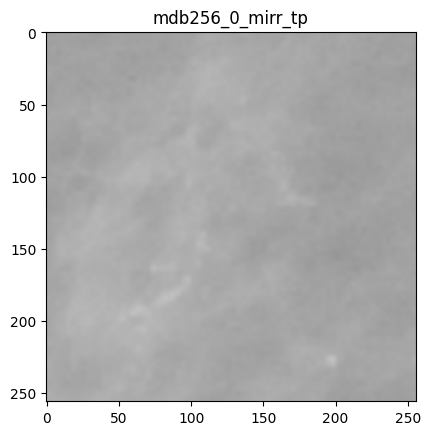

In [21]:
import cv2
import numpy as np
sample_img2 = cv2.imread(mammo.subsample_path[3062])
color = cv2.cvtColor(sample_img2, cv2.COLOR_BGR2RGB)
plt.imshow(color)
plt.title(mammo.index[3062])
plt.show()

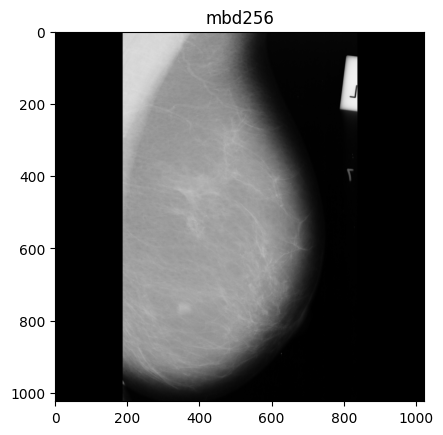

In [23]:
import cv2
import numpy as np
sample_img2 = cv2.imread("../content/mias-mammography/all-mias/mdb256.pgm")
color = cv2.cvtColor(sample_img2, cv2.COLOR_BGR2RGB)
plt.imshow(color)
plt.title("mbd256")
plt.show()

In [24]:
calc_raw = mammo[mammo.ab_class == "CALC"]
calc_raw.severity.value_counts()

,count
severity,
M,156
B,144


In [25]:
calc_bal = balance_by_severity(mammo,"CALC")
calc_bal.severity.value_counts()

,count
severity,
B,144
M,144


In [26]:
y = calc_bal.sample(28,random_state=42)
X = calc_bal.drop(y.index)

In [27]:
data_gen = ImageDataGenerator(validation_split=0.20, height_shift_range=0.10,width_shift_range=0.10,rotation_range=30,rescale=1/255.)

In [28]:
X_train = data_gen.flow_from_dataframe(X,x_col="subsample_path",y_col="severity",class_mode="categorical",target_size=(256,256),subset="training",color_mode="rgb",shuffle=True)
X_val = data_gen.flow_from_dataframe(X,x_col="subsample_path",y_col="severity",class_mode="categorical",target_size=(256,256),subset="validation",color_mode="rgb",shuffle=False)
y_val = data_gen.flow_from_dataframe(y,x_col="subsample_path",y_col="severity",class_mode="categorical",target_size=(256,256),subset="training",color_mode="rgb",shuffle=False)
y_test = data_gen.flow_from_dataframe(y,x_col="subsample_path",y_col="severity",class_mode="categorical",target_size=(256,256),subset="validation",color_mode="rgb",shuffle=False)

Found 208 validated image filenames belonging to 2 classes.
Found 52 validated image filenames belonging to 2 classes.
Found 23 validated image filenames belonging to 2 classes.
Found 5 validated image filenames belonging to 2 classes.


In [29]:
from tensorflow import keras

In [30]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
model16 = VGG16()
model19 = VGG19()
modelDN = DenseNet121()
modelMNV2 = MobileNetV2()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step
574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step
33188688/33188688 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Test The CNNs

# Model 1 - VGG16 + 512¶

In [32]:
model_16 = VGG16(weights = "imagenet", include_top=False,input_shape=(256,256,3))
model_16.trainable = False
flat1 = Flatten()(model_16.layers[-1].output)
class1 = Dense(512,activation="relu")(flat1)
#class2 = Dense(50,activation="relu")(class1)
#class3 = Dense(1024,activation="relu")(class2)
output = Dense(2,activation="softmax")(class1)
model_16 = Model(inputs=model_16.inputs, outputs=output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Model 2 - VGG19 + 512

In [33]:
model_19 = VGG19(weights = "imagenet", include_top=False,input_shape=(256,256,3))
model_19.trainable = False
flat19 = Flatten()(model_19.layers[-1].output)
class19 = Dense(512,activation="relu")(flat19)
#class2 = Dense(50,activation="relu")(class1)
#class3 = Dense(1024,activation="relu")(class2)
output19 = Dense(2,activation="softmax")(class19)
model_19 = Model(inputs=model_19.inputs, outputs=output19)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# MobileNet V2 + 512

In [34]:
modelMNV2 = MobileNetV2(weights = "imagenet", include_top=False,input_shape=(256,256,3))
modelMNV2.trainable = False
flatMNV2 = Flatten()(modelMNV2.layers[-1].output)
classMNV2 = Dense(512,activation="relu")(flatMNV2)
#class2 = Dense(50,activation="relu")(class1)
#class3 = Dense(1024,activation="relu")(class2)
outputMNV2 = Dense(2,activation="softmax")(classMNV2)
modelMNV2 = Model(inputs=modelMNV2.inputs, outputs=outputMNV2)

/tmp/ipython-input-34-465280877.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  modelMNV2 = MobileNetV2(weights = "imagenet", include_top=False,input_shape=(256,256,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# DenseNet 121 + 512

In [35]:
modelDN = DenseNet121(weights = "imagenet", include_top=False,input_shape=(256,256,3))
modelDN.trainable = False
flatDN = Flatten()(modelDN.layers[-1].output)
classDN = Dense(512,activation="relu")(flatDN)
#class2 = Dense(50,activation="relu")(class1)
#class3 = Dense(1024,activation="relu")(class2)
outputDN = Dense(2,activation="softmax")(classDN)
modelDN = Model(inputs=modelDN.inputs, outputs=outputDN)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Optimizers ES and Model Checkpoint

In [39]:
adam_opt = Adam()
model_loss = "categorical_crossentropy"
early_stopping = EarlyStopping(patience=200, restore_best_weights=True)
model_check_point_16 = ModelCheckpoint(filepath= './content/vgg16.keras',
                                    monitor='val_loss', verbose=0,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto', save_freq='epoch')
model_check_point_19 = ModelCheckpoint(filepath= './content/vgg19.keras',
                                    monitor='val_loss', verbose=0,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto', save_freq='epoch')
model_check_point_MNV2 = ModelCheckpoint(filepath= './content/mnv2.keras',
                                    monitor='val_loss', verbose=0,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto', save_freq='epoch')
model_check_point_DN = ModelCheckpoint(filepath= './content/dn.keras',
                                    monitor='val_loss', verbose=0,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto', save_freq='epoch')

In [40]:
model_16.compile(optimizer=adam_opt,loss=model_loss,metrics=["accuracy"])
model_19.compile(optimizer=adam_opt,loss=model_loss,metrics=["accuracy"])
modelMNV2.compile(optimizer=adam_opt,loss=model_loss,metrics=["accuracy"])
modelDN.compile(optimizer=adam_opt,loss=model_loss,metrics=["accuracy"])

In [41]:
import time

In [42]:
start_time = time.time()
history_16 = model_16.fit(X_train,validation_data=X_val,epochs=200,callbacks=[early_stopping,model_check_point_16],verbose=2)
end_time = time.time()
print("Training time for VGG16: ", end_time - start_time,"secs")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_634']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


7/7 - 40s - 6s/step - accuracy: 0.5481 - loss: 5.6620 - val_accuracy: 0.0000e+00 - val_loss: 1.0664
Epoch 2/200
7/7 - 6s - 838ms/step - accuracy: 0.6250 - loss: 0.6657 - val_accuracy: 0.0000e+00 - val_loss: 1.0158
Epoch 3/200
7/7 - 10s - 1s/step - accuracy: 0.6250 - loss: 0.6410 - val_accuracy: 0.0000e+00 - val_loss: 0.8895
Epoch 4/200
7/7 - 9s - 1s/step - accuracy: 0.6250 - loss: 0.6325 - val_accuracy: 0.0000e+00 - val_loss: 0.9747
Epoch 5/200
7/7 - 4s - 622ms/step - accuracy: 0.6250 - loss: 0.6228 - val_accuracy: 0.0000e+00 - val_loss: 0.9729
Epoch 6/200
7/7 - 6s - 809ms/step - accuracy: 0.6250 - loss: 0.6007 - val_accuracy: 0.0000e+00 - val_loss: 0.9957
Epoch 7/200
7/7 - 6s - 788ms/step - accuracy: 0.6394 - loss: 0.5829 - val_accuracy: 0.1923 - val_loss: 0.8211
Epoch 8/200
7/7 - 7s - 1s/step - accuracy: 0.6875 - loss: 0.5792 - val_accuracy: 0.2115 - val_loss: 0.8230
Epoch 9/200
7/7 - 4s - 602ms/step - accuracy: 0.6635 - loss: 0.5699 - val_accuracy: 0.0385 - val_loss: 0.9152
Epoch 10

In [43]:
vgg16_train_time = (end_time - start_time) / 60

In [44]:
vgg16_train_time

18.879923597971597

In [45]:
vgg16_train_history = pd.DataFrame(history_16.history)
file_name = "vgg_16_history.csv"
vgg16_train_history.to_csv(file_name)

In [46]:
vgg16_train_history.head()

,accuracy,loss,val_accuracy,val_loss
0,0.548077,5.662018,0.0,1.066364
1,0.625000,0.665728,0.0,1.015817
2,0.625000,0.641026,0.0,0.889480
3,0.625000,0.632458,0.0,0.974737
4,0.625000,0.622813,0.0,0.972922


In [47]:
ls "./vgg16"

ls: cannot access './vgg16': No such file or directory


In [48]:
!ls /content/*.keras

ls: cannot access '/content/*.keras': No such file or directory


In [49]:
!ls /content/vgg16.keras

ls: cannot access '/content/vgg16.keras': No such file or directory
